### Cross-2D Image Propagation using PAM without finetuning

#### Overview

This tutorial shows how to use **pre-trained PAM** for cross-2D image propagation, a powerful **zero-shot** segmentation approach that enables you to:

- **Label a small number of images** (typically just a handful of prompts) as references
- **Automatically predict segmentation masks** for the remaining unlabeled images in your dataset
- **Leverage cross-image attention** to propagate annotation information across similar images without any finetuning

We demonstrate the workflow on the public **HC18 fetal head circumference dataset** (van den Heuvel *et al.*, 2018, Zenodo DOI: [10.5281/zenodo.1322001](https://doi.org/10.5281/zenodo.1322001)). HC18 contains 2D ultrasound scans that clinicians use to measure fetal head circumference (HC) during pregnancy. In this demo PAM never saw ultrasound data during training; we only supply **three annotated HC18 slices as prompts** and directly propagate annotations to the rest of the study set. 

The aim is to demonstrate that the PAM for 3D volumetric segmentation possesses the capability for semantic propagation across modalities, objects, and images in 2D. This reveals the potential for PAM to serve as a zero-shot model, thereby assisting users in large-scale 2D image segmentation annotation.

#### Use Cases

This approach is particularly useful for:

1. **Medical Image Segmentation**: When you have limited annotated data but need to segment a large dataset (e.g., organ segmentation in ultrasound, CT, MRI scans, and so on)
2. **Domain Adaptation**: Adapting annotations from one image to similar images in the same domain
3. **Rapid Prototyping**: Bootstrapping large annotated datasets via an iterative cycle of *few prompts → propagation → manual vetting → new prompts → propagation → ...* without retraining the model

#### Data Requirements

To use this tutorial, you need:

1. **Pre-trained PAM Model**: A checkpoint file (`.pth`) of a PAM model, which can be accessed from Google Drive (https://drive.google.com/drive/folders/10fi5ZLFRnW5lCMVI7vMY61eTfOQlN9oI?usp=share_link) or Baidu Drive (https://pan.baidu.com/s/1WdTPG_ojCEeWR5qpl2_WzQ?pwd=mksh)
2. **Image Dataset**: For this demo we place the public HC18 images under `tutorials/datasets/HC18/images` (https://doi.org/10.5281/zenodo.1322001); you can substitute your own 2D dataset
3. **Guiding Data**: A tiny subset (three slices in this example) with manually created masks stored under `tutorials/datasets/HC18/guiding_prompts`

#### Expected Directory Structure

```
tutorials/
├── datasets/
│   └── HC18/
│       ├── guiding_images/   ### Three annotated ultrasound slices used as prompts
│       ├── guiding_prompts/  ### Binary masks for the same slices
│       ├── images/           ### All unlabeled HC18 ultrasound slices
│       └── preds/            ### Output directory for propagated predictions (created automatically)
├── checkpoints/
│   └── propmask.pth
└── cross-2d-image-propagation.ipynb
```

#### How It Works

1. **Load Pre-trained Model**: Initialize PAM with a pre-trained checkpoint
2. **Prepare Guiding Data**: Load and preprocess a small set of labeled images (images + masks) that act as prompts
3. **Propagate Annotations**: For each unlabeled image, use the guiding images as prompts to predict its segmentation mask
4. **Visualize Results**: Display the guiding images and predicted results

#### 1. Setup and Imports

Import necessary libraries and set up the environment.


In [1]:
import os 
import sys
import csv
import cv2 
import math
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn.functional as F
from tqdm import tqdm
from glob import glob 
from PIL import Image, ImageOps
from copy import deepcopy

### Add parent directory to path to import PAM model
sys.path.insert(0, "..")
from model.PAM import PAM

### Configuration
PAM_IMG_SIZE = 224  ### Input image size for PAM model (images will be resized to this)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}") 

Using device: cpu


In [2]:
def load_checkpoint(model, checkpoint, checkpoint_prefix="module.", printer=print):
    """
    Load model weights from a checkpoint file.
    
    This function handles different checkpoint formats and key naming conventions
    (e.g., when models are saved with DataParallel/DistributedDataParallel prefixes).
    
    Args:
        model: The model instance to load weights into
        checkpoint: Path to the checkpoint file (.pth)
        checkpoint_prefix: Prefix to remove from checkpoint keys (default: "module.")
        printer: Function to use for printing messages (default: print)
    
    Returns:
        model: Model with loaded weights
    """
    key_num = 0
    state_dict = torch.load(checkpoint, map_location=DEVICE)
    
    ### Handle different checkpoint formats
    if "model_state_dict" in state_dict:
        state_dict = state_dict["model_state_dict"]
    
    model_state_dict = model.state_dict()
    
    ### Match and load weights, handling key name differences
    for key, value in state_dict.items():
        tmp_key = key.replace(checkpoint_prefix, "")
        if tmp_key in model_state_dict:
            model_state_dict[tmp_key] = value 
            key_num += 1
    
    p = model.load_state_dict(model_state_dict)
    printer(f"Loaded checkpoint from {checkpoint} ({key_num}/{len(model_state_dict)}): {p}")
    return model

### ============================================================================
### MODEL CONFIGURATION
### ============================================================================
### TODO: Modify the checkpoint path and model parameters according to your setup
### The checkpoint path should point to your pre-trained PAM model
chk_file = "./checkpoints/propmask.pth"

### Initialize PAM model with architecture parameters
### These parameters should match the model architecture used during training
pam_model = PAM(
    conv_dim=2,              ### 2D convolutions (use 3 for 3D)
    input_channels=1,        ### Number of input channels (1 for grayscale, 3 for RGB)
    n_stages=6,              ### Number of U-Net encoder/decoder stages
    max_channels=512,        ### Maximum number of channels in the network
    num_classes=2,           ### Number of segmentation classes (background + foreground)
    deep_supervision=True,   ### Use deep supervision (multi-scale predictions)
    n_attn_stage=4,         ### Number of stages with cross-attention
    from_scratch_ratio=0.0  ### Ratio of layers trained from scratch (0.0 = all pretrained)
)

### Load pre-trained weights
pam_model = load_checkpoint(pam_model, chk_file)
pam_model = pam_model.to(DEVICE)
pam_model.eval()  ### Set to evaluation mode
print("Model loaded and ready for inference!")

Loaded checkpoint from ./checkpoints/propmask.pth (408/408): <All keys matched successfully>
Model loaded and ready for inference!


#### 2. Prepare Data

This notebook uses the **HC18 fetal head circumference dataset** (van den Heuvel *et al.*, 2018) as an example. Please refer to the above description as details.

#### 3. Helper Functions and Inference
##### 3.1 Image Preprocessing Functions


In [3]:
def _compute_dynamic_internal_torch(guiding_x: torch.Tensor, guiding_prp: torch.Tensor, device) -> tuple:
    """
    Compute dynamic intensity normalization range based on mask region.
    
    This function extracts intensity statistics from the foreground region (mask > 0)
    to compute normalization parameters. This helps handle different intensity ranges
    across images in the dataset.
    
    Args:
        guiding_x: Input image tensor, shape (1,1,h,w), (1,h,w), or (h,w)
        guiding_prp: Binary mask tensor, shape (1,1,h,w), (1,h,w), or (h,w)
        device: Device to perform computation on
    
    Returns:
        tuple: (img_min, img_max) - 5th and 95th percentiles of foreground intensities
    """
    ### Handle different input tensor dimensions
    if guiding_x.ndim == 4:
        img2d = guiding_x[0, 0]
    elif guiding_x.ndim == 3:
        img2d = guiding_x[0]
    elif guiding_x.ndim == 2:
        img2d = guiding_x
    else:
        raise ValueError("guiding_x must be (h,w), (1,h,w), or (1,1,h,w)")
    
    ### Extract mask region
    if guiding_prp.ndim == 4:
        m2d = guiding_prp[0, 0] > 0
    elif guiding_prp.ndim == 3:
        m2d = guiding_prp[0] > 0
    elif guiding_prp.ndim == 2:
        m2d = guiding_prp > 0
    else:
        raise ValueError("guiding_prp must be (h,w), (1,h,w), or (1,1,h,w)")
    
    ### Get intensity values from foreground region
    vals = img2d[m2d]
    if vals.numel() == 0:
        ### Fallback: use entire image if mask is empty
        vals = img2d.reshape(-1)
    
    ### Compute 5th and 95th percentiles for robust normalization
    q = torch.quantile(vals, torch.tensor([0.05, 0.95], device=device))
    img_min = q[0]
    img_max = q[1]
    return img_min, img_max


def _pad_and_resize(pil_img: Image.Image, target_size: int, is_mask: bool = False) -> Image.Image:
    """
    Pad image to square and resize to target size.
    
    This function ensures all images have the same size while preserving aspect ratio
    by adding padding. Images are centered in the padded square.
    
    Args:
        pil_img: Input PIL Image
        target_size: Target size for the output image (width = height = target_size)
        is_mask: If True, use nearest-neighbor resampling (for masks), 
                 otherwise use bilinear resampling (for images)
    
    Returns:
        PIL Image: Padded and resized image
    """
    w, h = pil_img.size  ### PIL uses (width, height) format
    max_side = max(w, h)

    ### Calculate padding to center the image in a square
    pad_left   = (max_side - w) // 2
    pad_right  = max_side - w - pad_left
    pad_top    = (max_side - h) // 2
    pad_bottom = max_side - h - pad_top

    ### Pad with zeros (black). For images, you could use mean intensity instead
    fill = 0
    padded = ImageOps.expand(pil_img, border=(pad_left, pad_top, pad_right, pad_bottom), fill=fill)

    ### Resize to target size
    ### Use nearest-neighbor for masks to preserve binary values, bilinear for images
    resample = Image.NEAREST if is_mask else Image.BILINEAR
    resized = padded.resize((target_size, target_size), resample=resample)
    return resized


##### 3.2 Load Guiding Data


In [4]:
def _load_guiding_data(dataset_dir):
    """
    Load and preprocess guiding images and their corresponding masks.
    
    This function:
    1. Loads images and masks from file paths
    2. Converts them to grayscale
    3. Pads and resizes to model input size
    4. Normalizes intensities based on foreground regions
    5. Converts to PyTorch tensors
    
    Args:
        dataset_dir: Directory containing guiding images and masks
    
    Returns:
        tuple: (guiding_xs, guiding_prompts, norm_img_mins, norm_img_maxs)
            - guiding_xs: Normalized image tensors, shape (N, 1, H, W)
            - guiding_prompts: Binary mask tensors, shape (N, 1, H, W)
            - norm_img_mins: List of minimum values used for normalization
            - norm_img_maxs: List of maximum values used for normalization
    """
    guiding_data = {"img_files": [], "prp_files": []}
    for img_file in glob(os.path.join(dataset_dir, "guiding_images", "*.png")):
        prp_file = img_file.replace("guiding_images", "guiding_prompts")
        assert os.path.exists(prp_file), f"Corresponding mask file {prp_file} does not exist"
        guiding_data["img_files"].append(img_file)
        guiding_data["prp_files"].append(prp_file)

    guiding_xs, guiding_prompts = [], []
    ### Load and preprocess each guiding image-mask pair
    for image_file, mask_file in tqdm(zip(guiding_data["img_files"], guiding_data["prp_files"]), 
                                      desc="Loading guiding data"):
        ### Load images as grayscale
        image = Image.open(image_file).convert("L")
        mask = Image.open(mask_file).convert("L")

        ### Pad and resize to model input size
        image = _pad_and_resize(image, PAM_IMG_SIZE, is_mask=False)
        mask  = _pad_and_resize(mask,  PAM_IMG_SIZE, is_mask=True)

        ### Convert to numpy arrays
        guiding_xs.append(np.array(image))  ### (H, W)
        guiding_prompts.append((np.array(mask) > 0).astype(np.uint8))  ### (H, W) binary

    ### Convert to PyTorch tensors and move to device
    guiding_xs = torch.from_numpy(np.array(guiding_xs)).float().unsqueeze(1).to(DEVICE)  ### (N, 1, H, W)
    guiding_prompts = torch.from_numpy(np.array(guiding_prompts)).float().unsqueeze(1).to(DEVICE)  ### (N, 1, H, W)

    ### Normalize each image based on its foreground intensity distribution
    ### This helps handle different intensity ranges across images
    norm_img_mins, norm_img_maxs = [], []
    for i in range(len(guiding_xs)):
        img_min, img_max = _compute_dynamic_internal_torch(guiding_xs[i], guiding_prompts[i], DEVICE)
        denom = torch.clamp(img_max - img_min, min=1e-6)
        ### Normalize to [0, 1] range
        guiding_xs[i] = torch.clamp((guiding_xs[i] - img_min) / denom, 0.0, 1.0)

        ### Store normalization parameters for later use
        norm_img_mins.append(img_min)
        norm_img_maxs.append(img_max)

    print(f"Loaded {len(guiding_xs)} labeled data to be used as guiding data")
    return guiding_xs, guiding_prompts, norm_img_mins, norm_img_maxs


##### 3.3 Inference Function


In [5]:
def infer_one_image(infer_img_file, pred_file, guiding_params):
    """
    Predict segmentation mask for a single image using guiding data as prompts.
    
    This function:
    1. Loads and preprocesses the input image
    2. Normalizes it using the same normalization parameters as guiding images
    3. Runs PAM model with cross-attention between guiding and inference images
    4. Aggregates multi-scale predictions
    5. Saves the predicted mask
    
    Args:
        infer_img_file: Path to the input image to segment
        pred_file: Path where the predicted mask will be saved
        guiding_params: Tuple containing:
            - guiding_xs: Normalized guiding images, shape (N, 1, H, W)
            - guiding_prompts: Guiding masks, shape (N, 1, H, W)
            - norm_img_mins: Normalization minimum values
            - norm_img_maxs: Normalization maximum values
    """
    guiding_xs, guiding_prompts, norm_img_mins, norm_img_maxs = guiding_params

    ### Load and preprocess inference image
    infer_img_pil = Image.open(infer_img_file).convert("L")
    infer_img = _pad_and_resize(infer_img_pil, PAM_IMG_SIZE, is_mask=False)
    adjacent_x = torch.from_numpy(np.array(infer_img)).float().to(DEVICE)  ### (H, W)

    ### Normalize inference image using each guiding image's normalization parameters
    ### This creates multiple normalized versions, one for each guiding image
    adjacent_xs = []
    for i in range(guiding_xs.shape[0]):
        img_min, img_max = norm_img_mins[i], norm_img_maxs[i]
        denom = torch.clamp(img_max - img_min, min=1e-6)
        adjacent_x_i = torch.clamp((adjacent_x - img_min) / denom, 0.0, 1.0)
        adjacent_xs.append(adjacent_x_i)
    
    ### Stack to create batch: (N_prp, 1, 1, H, W)
    ### N_prp = number of guiding images, each will attend to the inference image
    adjacent_xs = torch.stack(adjacent_xs, dim=0).unsqueeze(1).unsqueeze(2)

    ### Prepare input dictionary for PAM model
    input_data = {
        "guiding_x": guiding_xs,  ### (N_prp, 1, H, W) - guiding images
        "guiding_prp": guiding_prompts.squeeze(1),  ### (N_prp, H, W) - guiding masks
        "adjacent_x": adjacent_xs,  ### (N_prp, 1, 1, H, W) - inference image (repeated for each guide)
    }
    
    ### Run inference
    with torch.no_grad():
        pred_dict = pam_model(input_data)

    ### Aggregate multi-scale predictions (if deep supervision is used)
    preds = [pred_dict["predictions"][0]]
    pred_size = preds[0].size()[-2:]
    
    ### Resize all predictions to the same size
    for pred in pred_dict["predictions"][1:]:
        preds.append(F.interpolate(pred, size=pred_size, mode="bilinear", align_corners=True))
    
    ### Stack predictions: (N_scale, N_prp, N_class, H, W)
    preds = torch.stack(preds, dim=0)
    
    ### Average across all scales and all guiding images
    preds = torch.mean(preds.view(-1, *preds.shape[-3:]), dim=0)  ### (N_class, H, W)
    
    ### Convert to probability and binary prediction
    prob = torch.softmax(preds, dim=0)[1].detach().cpu().numpy()  ### (H, W) - foreground probability
    pred = torch.argmax(preds, dim=0).detach().cpu().numpy()  ### (H, W) - binary prediction
    
    ### Resize prediction back to original image size and save
    pred_pil = Image.fromarray(pred.astype(np.uint8) * 255).resize(infer_img_pil.size)
    pred_pil.save(pred_file)


#### 4. Run Inference

Load guiding data and perform inference on all unlabeled images.


In [6]:
### ============================================================================
### SETUP DATASET DIRECTORY
### ============================================================================
### TODO: Modify this path to match your dataset structure
dataset_dir = "datasets/HC18_subset"

### ============================================================================
### SETUP OUTPUT DIRECTORY
### ===========================================================================
pred_dir = os.path.join(dataset_dir, "preds")
os.makedirs(pred_dir, exist_ok=True)

### ============================================================================
### LOAD GUIDING DATA
### ============================================================================
### Load and preprocess all guiding images and masks
### This only needs to be done once at the beginning
guiding_params = _load_guiding_data(dataset_dir)

### ============================================================================
### RUN INFERENCE ON ALL UNLABELED IMAGES
### ============================================================================
### Process each image in the inference set
infer_dir = os.path.join(dataset_dir, "images")
infer_files = glob(os.path.join(infer_dir, "*.png"))

for infer_file in tqdm(infer_files, desc="Running inference"):          
    pred_file = os.path.join(pred_dir, f"{os.path.basename(infer_file)}")
    
    ### Run inference and save prediction
    infer_one_image(infer_file, pred_file, guiding_params)

print(f"\nInference complete! Predictions saved to: {pred_dir}")


Loading guiding data: 3it [00:00, 18.78it/s]


Loaded 3 labeled data to be used as guiding data


Running inference: 100%|██████████| 20/20 [01:11<00:00,  3.59s/it]


Inference complete! Predictions saved to: datasets/HC18_subset/preds


#### 5. Visualize Results

Visualize the guiding images (with ground truth masks) and predicted results.


Found 20 prediction files
Matched 20 images with predictions
['datasets/HC18_subset/guiding_images/1_HC.png', 'datasets/HC18_subset/guiding_images/2_HC.png', 'datasets/HC18_subset/guiding_images/3_HC.png'] ++++++++++


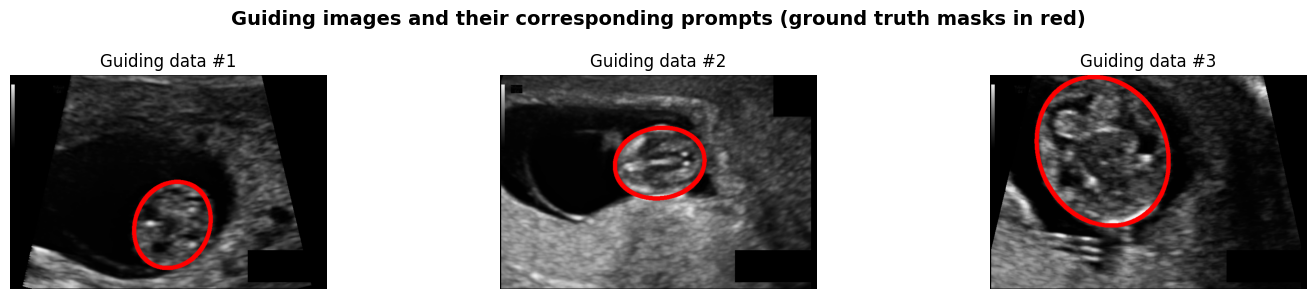

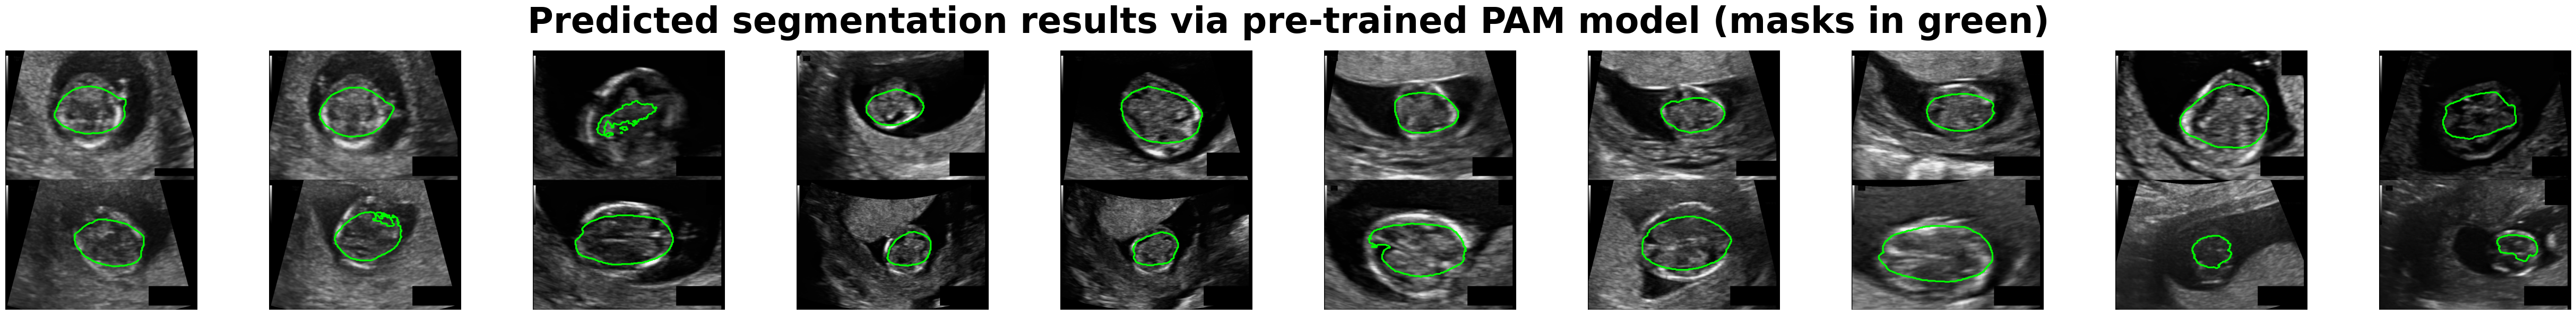

In [7]:
def gray_to_rgb(gray_img):
    """
    Convert grayscale image to RGB format (for visualization).
    
    Args:
        gray_img: Grayscale image array
    
    Returns:
        PIL Image: RGB image
    """
    return Image.fromarray(np.stack([
        gray_img * 255, np.zeros_like(gray_img), np.zeros_like(gray_img)
    ], axis=2).astype(np.uint8)).convert("RGB")


def draw_contours(image_pil, mask_pil, color=(255, 0, 0), thickness=5):
    """
    Draw contour outlines of a mask on an image.
    
    Args:
        image_pil: PIL Image (RGB or grayscale)
        mask_pil: PIL Image containing binary mask
        color: RGB tuple for contour color (default: red)
        thickness: Thickness of contour lines
    
    Returns:
        PIL Image: Image with contours drawn
    """
    pred_mask_uint8 = (np.array(mask_pil) * 255).astype(np.uint8)
    contours, _ = cv2.findContours(pred_mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    viz_image = np.array(image_pil).copy()
    cv2.drawContours(viz_image, contours, -1, color, thickness)
    return Image.fromarray(viz_image)


import matplotlib.gridspec as gridspec

### ============================================================================
### LOAD DATA FOR VISUALIZATION
### ============================================================================
### TODO: Modify these paths to match your dataset structure
guiding_img_dir = os.path.join(dataset_dir, "guiding_images") 
guiding_mask_dir = os.path.join(dataset_dir, "guiding_prompts") 
pred_dir = os.path.join(dataset_dir, "preds")     
infer_img_dir = os.path.join(dataset_dir, "images")  

### Load guiding images and masks
guiding_img_files = sorted(glob(os.path.join(guiding_img_dir, "*.png")))  ### Adjust number as needed
guiding_mask_files = [f.replace(guiding_img_dir, guiding_mask_dir) for f in guiding_img_files]

### Load prediction files
pred_files = sorted(glob(os.path.join(pred_dir, "*.png")))
print(f"Found {len(pred_files)} prediction files")

### Match prediction files with their corresponding original images
### Prediction files are named as: {original_image_basename}.png
infer_img_files = []
for pred_file in pred_files:
    pred_basename = os.path.basename(pred_file)
    ### Remove .png extension to get original image name
    original_name = pred_basename.replace(".png", "")
    ### Try to find the original image (supports common extensions)
    for ext in [".png", ".jpg", ".jpeg", ".PNG", ".JPG", ".JPEG"]:
        img_path = os.path.join(infer_img_dir, original_name + ext)
        if os.path.exists(img_path):
            infer_img_files.append(img_path)
            break
    else:
        ### If not found, try with .png extension
        img_path = os.path.join(infer_img_dir, original_name)
        if os.path.exists(img_path):
            infer_img_files.append(img_path)

print(f"Matched {len(infer_img_files)} images with predictions")

### ============================================================================
### VISUALIZE GUIDING DATA
### ============================================================================
### Display all guiding images with their ground truth masks overlaid
if len(guiding_img_files) > 0:
    print(guiding_img_files, "++++++++++")
    fig = plt.figure(figsize=(len(guiding_img_files) * 5, 3))
    gs = gridspec.GridSpec(1, len(guiding_img_files), wspace=0, hspace=0)
    
    for i in range(len(guiding_img_files)):
        ax = plt.subplot(gs[i])
        image_pil = Image.open(guiding_img_files[i]).convert("RGB")
        ### Draw red contours for ground truth masks
        if os.path.exists(guiding_mask_files[i]):
            ax.imshow(draw_contours(image_pil, Image.open(guiding_mask_files[i]).convert("L"), 
                                   color=(255, 0, 0), thickness=10))
        else:
            ax.imshow(image_pil)
        ax.set_title(f"Guiding data #{i+1}")
        ax.axis("off")
    
    plt.suptitle("Guiding images and their corresponding prompts (ground truth masks in red)", 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    plt.close()
else:
    print("No guiding images found. Please check the guiding_img_dir path.")

### ============================================================================
### VISUALIZE PREDICTIONS
### ============================================================================
### Display a random subset of predicted results
if len(pred_files) > 0 and len(infer_img_files) > 0:
    N_viz = min(20, len(pred_files))  ### Show up to 20 images
    N_viz_per_row = 10
    N_rows = math.ceil(N_viz / N_viz_per_row)
    
    fig = plt.figure(figsize=(N_viz_per_row * 5, N_rows * 3))
    gs = gridspec.GridSpec(N_rows, N_viz_per_row, wspace=0, hspace=0)
    
    ### Randomly sample images to visualize
    if len(pred_files) == N_viz:
        indices = np.arange(len(pred_files))
    else:
        indices = np.random.choice(len(pred_files), size=N_viz, replace=False)
    
    for k, idx in enumerate(indices):
        row_idx = k // N_viz_per_row
        col_idx = k % N_viz_per_row
        ax = plt.subplot(gs[row_idx, col_idx])
        
        if idx < len(infer_img_files) and os.path.exists(infer_img_files[idx]):
            image_pil = Image.open(infer_img_files[idx]).convert("RGB")
            ### Draw green contours for predicted masks
            if os.path.exists(pred_files[idx]):
                ax.imshow(draw_contours(image_pil, Image.open(pred_files[idx]).convert("L"), 
                                       color=(0, 255, 0), thickness=5))
            else:
                ax.imshow(image_pil)
        else:
            ### If image not found, just show the prediction
            if os.path.exists(pred_files[idx]):
                pred_pil = Image.open(pred_files[idx]).convert("L")
                ax.imshow(pred_pil, cmap='gray')
        ax.axis("off")
    
    plt.suptitle("Predicted segmentation results via pre-trained PAM model (masks in green)", 
                 fontsize=48, fontweight='bold')
    plt.tight_layout()
    plt.show()
    plt.close()
else:
    print("No predictions found. Please check the pred_dir path and ensure inference has been run.")

#### Tips for Better Results
- **Choose diverse guiding images**: Select guiding images that represent the full range of variability in your dataset (different orientations, sizes, appearances, etc.)
- **More guiding images**: Generally, 10-20 guiding images work well, but you can experiment with different numbers
- **Iterative guidance augmentation**: Start with a small set of manually annotated images, then use the model to predict on unlabeled data. Select the top-K highest quality predictions to expand your guiding set, enabling efficient large-scale data annotation through this iterative process.
